In [10]:
import py_wave_runup
from examples.evaluate_returnperiods import load_design_data, load_existing_data, load_timeseries_data
import sys
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import py_wave_runup
import seaborn as sns


In [11]:
#Run this if you want to compare different scenarios and return periods
#=========================================================
#Wave Dataset
#=========================================================
Tp_returnvals = pd.read_csv('data\Tp_return_vals.csv')
Tp=np.reshape(Tp_returnvals.drop(columns='return period').values, (15,))
Hs_returnvals = pd.read_csv('data\Hs_return_vals.csv')
Hs=np.reshape(Hs_returnvals.drop(columns='return period').values, (15,))
returnperiod = [5]*3 + [10] * 3 + [20]*3 + [50]*3 + [100]*3
MHW = 4.3#m
#=========================================================
#Slope Info Dataset
#=========================================================
existing = 'data\Adamson_M_Z_existing.csv'
design = 'data\Adamson_M_Z_design.csv'
df_stock = load_existing_data(existing, Hs, Tp, returnperiod)
df = load_design_data(design, Hs, Tp, returnperiod)
df = df[df.returnperiod==10]
df.loc[(df.dtoeSWL>1),'scenario'] = 3
stock = py_wave_runup.models.Stockdon2006(Hs=df_stock.hs,beta=df_stock.beta,Tp=df_stock.tp,spectral_wave_period=True,h=10)
df_stock['r2'] = stock.R2*3.3
df_stock['method'] = 'Stockdon'
df_stock['scenario'] = 1



In [5]:
# #Run this if you want to run time series
# df = load_timeseries_data('data\Hs_ts.csv','data\Tp_ts.csv', dtoe=2, slope=1/10)
# df.bsand = 1/100

In [12]:
blen = py_wave_runup.models.Blenkinsopp2022(Hs=df.hs,beta=df.beta,bsand=df.bsand,bberm=df.bberm,dtoeSWL=df.dtoeSWL,Tp=df.tp,spectral_wave_period=True,h=10)
euro = py_wave_runup.models.EurOtop2018(Hs=df.hs,beta=df.beta,bsand=df.bsand,bberm=df.bberm,dtoeSWL=df.dtoeSWL,Tp=df.tp,spectral_wave_period=True,h=10)
poate = py_wave_runup.models.Poate2016(Hs=df.hs,beta=df.beta,bsand=df.bsand,bberm=df.bberm,dtoeSWL=df.dtoeSWL,Tp=df.tp,spectral_wave_period=True,h=10)
stock = py_wave_runup.models.Stockdon2006(Hs=df.hs,beta=df.beta,bsand=df.bsand,bberm=df.bberm,dtoeSWL=df.dtoeSWL,Tp=df.tp,spectral_wave_period=True,h=10)

df_taw = df.copy(deep=True)
df_poate = df.copy(deep=True)
df_stock = df.copy(deep=True)

df_stock['r2'] = (stock.R2 + MHW)*3.3
df_stock['method'] = ['Stockdon'] * len(df.hs)
df['r2'] = blen.R2_eq21*3.3

df_taw['r2'] = euro.R2(gamma_f=0.70)*3.3
df_poate['r2'] = poate.R2()*3.3
df_poate['method'] = ['Poate 2016'] * len(df.hs)
df_taw['method'] = ['TAW'] * len(df.hs)
df['method'] = ['Blenkinsopp 2022'] * len(df.hs)

df_full = pd.concat([df, df_taw, df_poate, df_stock])
df_full['hs'] = df_full['hs']*3.3


In [ ]:
#Run this for continuous data plot
# fig, ax = pl.subplots(1,1)
# a = sns.scatterplot(x='hs',y='r2',hue='method',data=df_full)
# pl.legend(loc='upper left')
# ax.set_xlabel('Hs [ft]')
# ax.set_ylabel('R2% [ft]')
# ax.set_xlim((3,8))
# ax.set_ylim((0,10))
# pl.savefig('hsvsr2vsmethod.png')

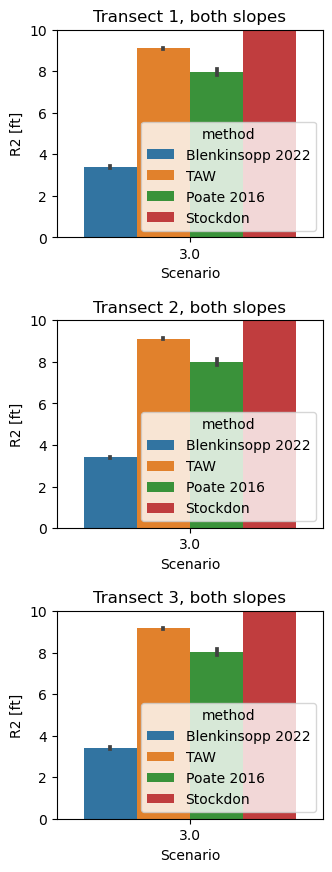

In [13]:
#Run this for scenario plotting
fig, ax = pl.subplots(3,1)
pl.tight_layout()
fig.set_size_inches((3,9))
for i in range(3):
    a = sns.barplot(x='scenario',y='r2', hue='method', data=df_full[df_full.transect==i+1],ax = ax[i])
    ax[i].set_ylim((0,10))
    ax[i].set_ylabel('R2 [ft]')
    ax[i].set_xlabel('Scenario')
    ax[i].set_title('Transect {0}, both slopes'.format(i+1))